# Pengenalan Wajah Bermasker Dan Tidak Menggunakan CNN
Mochammad Arya Salsabila ( 19081010001 ) / Nadhif Mahardika Awandi ( 19081010064 ) / Kecerdasan Buatan Paralel D Tahun 2021

![Banner](https://storage.googleapis.com/kaggle-datasets-images/809358/1386555/25ee018da53319cffea1c5080c7c9857/dataset-cover.jpg?t=2020-08-07-17-42-48)

# Download Dataset

Dataset yang digunakan didapatkan dari https://www.kaggle.com/omkargurav/face-mask-dataset. 

```bash
└─── data
    |─── with mask
    └─── without mask
```

# Import Library

In [1]:
import os
import shutil
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

# Mempersiapkan Dataset

Mengekstrak dataset yang telah didownload dan melihat isi foldernya.

In [2]:
local_zip = "D:/Code/Notebook/realtime-facemask-detection-cnn/data.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("D:/Code/Notebook/realtime-facemask-detection-cnn")
zip_ref.close()

os.listdir("D:/Code/Notebook/realtime-facemask-detection-cnn/data")

['without_mask', 'with_mask']

Mengecek total image pada direktori with mask dan wihtout mask.

In [3]:
total_with_mask = len(os.listdir("D:/Code/Notebook/realtime-facemask-detection-cnn/data/with_mask"))
total_without_mask = len(os.listdir("D:/Code/Notebook/realtime-facemask-detection-cnn/data/without_mask"))

total = total_with_mask + total_without_mask

print("Total : {}".format(total))
print("With mask : {}".format(total_with_mask))
print("Without mask : {}".format(total_without_mask))

Total : 7553
With mask : 3725
Without mask : 3828


Membuat sub direktori train dan validation di dalam direktori data, sehingga struktur direktori data menjadi:

```bash
└─── data
    |─── train
    |   |─── with mask ( 80% )
    |   └─── without mask ( 80% )
    |─── validation 
    |   |─── with mask ( 20% )
    |   └─── without mask ( 20% )
    |─── with mask ( original )
    └─── without mask ( original )
```

In [4]:
base_dir = "D:/Code/Notebook/realtime-facemask-detection-cnn/data"
without_mask_dir = os.path.join(base_dir, "without_mask")
with_mask_dir = os.path.join(base_dir, "with_mask")

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

train_with_mask_dir = os.path.join(train_dir, "with_mask")
train_without_mask_dir = os.path.join(train_dir, "without_mask")

validation_with_mask_dir = os.path.join(validation_dir, "with_mask")
validation_without_mask_dir = os.path.join(validation_dir, "without_mask")

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

if not os.path.exists(train_with_mask_dir):
    os.mkdir(train_with_mask_dir)
if not os.path.exists(train_without_mask_dir):
    os.mkdir(train_without_mask_dir)

if not os.path.exists(validation_with_mask_dir):
    os.mkdir(validation_with_mask_dir)
if not os.path.exists(validation_without_mask_dir):
    os.mkdir(validation_without_mask_dir)

Membagi dataset with mask dan without mask menjadi 2 bagian, yaitu train dan validation dengan proporsi 80% dan 20%.

In [5]:
train_with_mask, validation_with_mask = train_test_split(os.listdir(with_mask_dir), test_size = 0.2)
train_without_mask, validation_without_mask = train_test_split(os.listdir(without_mask_dir), test_size = 0.2)

for i in train_with_mask:
    shutil.copy(os.path.join(with_mask_dir, i), os.path.join(train_with_mask_dir, i))
for i in train_without_mask:
    shutil.copy(os.path.join(without_mask_dir, i), os.path.join(train_without_mask_dir, i))

for i in validation_with_mask:
    shutil.copy(os.path.join(with_mask_dir, i), os.path.join(validation_with_mask_dir, i))
for i in validation_without_mask:
    shutil.copy(os.path.join(without_mask_dir, i), os.path.join(validation_without_mask_dir, i))

Memproses data sebelum di load menggunakan ImageDataGenerator(). ImageDataGenerator() dapat melakukan preprocessing, pelabelan sampel otomatis, dan augmentasi gambar.

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = "nearest"
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = "nearest"
)

Load data ke dalam memori dengan fungsi flow_from_directory(). Cara menentukan class_mode yang digunakan:
- Untuk klasifikasi 2 kelas maka gunakan binary. 
- Untuk klasifikasi 3 kelas atau lebih maka gunakan categorical.

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = "binary"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = "binary"
)

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


Menampilkan kelas-kelas pada dataset.

In [8]:
print(train_generator.class_indices)

{'with_mask': 0, 'without_mask': 1}


# Membuat Arsitektur Model CNN

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

# Compile Model

Menentukan loss function, optimizer, dan metrics yang akan digunakan.

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.optimizers.Adam(),
              metrics=["accuracy"])

- Karena class mode yang digunakan pada flow data adalah binary maka loss functionnya menggunakan binary crossentropy. Sebaliknya jika class mode yang digunakan pada flow data adalah categorical maka loss functionnya menggunakan categorical crossentropy.
- Optimizer yang digunakan adalah adam optimizer karena lebih efisien secara komputasi dan kebutuhan memorinya yang kecil.
- Metrics accuracy dipilih karena nilai matriks yang diukur pada project ini menggunakan nilai akurasi.

# Membuat Callback

Callback ini berfungsi untuk menghentikan proses training meskipun epoch belum berakhir dengan syarat accuracy yang didapatkan saat training telah melebihi ACCURACY THRESHOLD yang telah ditentukan yaitu 96%.

In [11]:
ACCURACY_THRESHOLD = 0.96

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("accuracy") > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" % (ACCURACY_THRESHOLD * 100))
            self.model.stop_training = True
            
callbacks = myCallback()

# Melatih Model

Karena model telah dicompile maka model tersebut kini telah siap untuk ditraining. Untuk melatih model dapat menggunakan fungsi fit().

In [12]:
STEP_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = validation_generator.n // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch = STEP_PER_EPOCH,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    verbose = 2,
    callbacks = [callbacks]
)

Epoch 1/20


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


188/188 - 135s - loss: 0.3447 - accuracy: 0.8446 - val_loss: 0.2277 - val_accuracy: 0.9089 - 135s/epoch - 717ms/step
Epoch 2/20
188/188 - 133s - loss: 0.2216 - accuracy: 0.9171 - val_loss: 0.1908 - val_accuracy: 0.9269 - 133s/epoch - 708ms/step
Epoch 3/20
188/188 - 123s - loss: 0.1895 - accuracy: 0.9324 - val_loss: 0.1766 - val_accuracy: 0.9328 - 123s/epoch - 652ms/step
Epoch 4/20
188/188 - 113s - loss: 0.1784 - accuracy: 0.9391 - val_loss: 0.1574 - val_accuracy: 0.9428 - 113s/epoch - 602ms/step
Epoch 5/20
188/188 - 108s - loss: 0.1701 - accuracy: 0.9393 - val_loss: 0.1511 - val_accuracy: 0.9441 - 108s/epoch - 575ms/step
Epoch 6/20
188/188 - 107s - loss: 0.1507 - accuracy: 0.9473 - val_loss: 0.1417 - val_accuracy: 0.9461 - 107s/epoch - 572ms/step
Epoch 7/20
188/188 - 108s - loss: 0.1380 - accuracy: 0.9524 - val_loss: 0.1163 - val_accuracy: 0.9535 - 108s/epoch - 574ms/step
Epoch 8/20
188/188 - 108s - loss: 0.1196 - accuracy: 0.9559 - val_loss: 0.1290 - val_accuracy: 0.9561 - 108s/epoch 

# Visualisasi Data

Membuat visualisasi data untuk menampilkan model accuracy dan model loss selama proses training berlangsung.

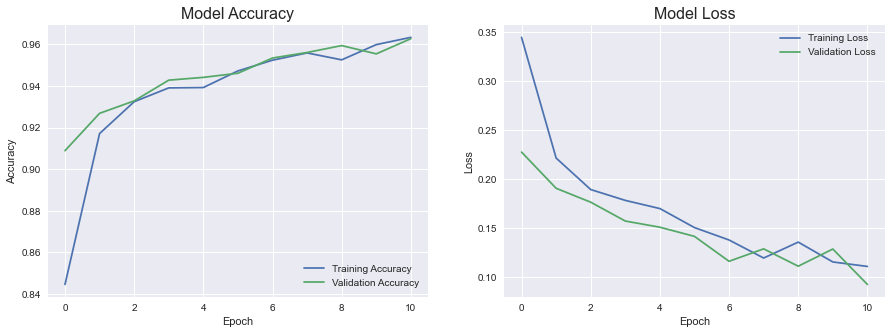

In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.style.use("seaborn")
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

ax[0].plot(acc, label = "Training Accuracy")
ax[0].plot(val_acc, label = "Validation Accuracy")
ax[0].legend(loc = "lower right")
ax[0].set_title("Model Accuracy", fontsize = 16)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(loss, label = "Training Loss")
ax[1].plot(val_loss, label = "Validation Loss")
ax[1].legend(loc = "upper right")
ax[1].set_title("Model Loss", fontsize = 16)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.show()

# Save Model

In [27]:
from keras.models import save_model

model.save("D:/Code/Notebook/realtime-facemask-detection-cnn/model_with_opt.h5")
model.save("D:/Code/Notebook/realtime-facemask-detection-cnn/model_without_opt.h5", include_optimizer = False)

Model yang telah disimpan akan digunakan untuk pengenalan wajah bermasker dan tidak menggunakan:

- Foto ( facemask_detection_cnn_photo.ipynb )
- Video Realtime ( facemask_detection_cnn_video.ipynb )